### Decisions to make
### 1. 
1. 
```
data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())
y = data['season_end_top_10']
```
2. 
```
data['top_10_finish'] = np.where(data['podium'] <= 10, 1, 0)
y = data['top_10_finish']
```
3. 
```
y = data['podium'] 
```
Key Differenced: 
* The first method determines if a driver finished in the top 10 in terms of points at the end of a season.
* The first method uses group-wise operation (grouping by 'season'), while the second line applies a condition to each row independently.
* The second method simply marks whether a driver finished in the top 10 in a particular event (not considering the entire season).
* The third method is just something I tried, seem pretty bad.

From the looks of it, method 1 makes best predictions. Gets all first 3 places correct with RL and NBC.

### 2. 
What kind of accuracy do we want to calculate?
1. In top 10 (True/False)
2. By standing

Currently, I am computing the accuracy with top 10 seasonal standing, i.e., final standing, by `driver_name`.
```
accuracy = calc_acc(y_test, y_pred)
```
where `y_pred` is computed by:
1. predicting the ranking of each round of a season
2. assign points to the top 10
3. sum all points by driver
4. return driver_name of the top 10 drivers with most point in sorted order

and `y_test` is computed in similar fasion but using real data.

I personally think this accuracy isn't that meaningful because we are only comparing a single season. 

If we were to predict the seasonal top 10 for every season, this method of computing accuracy would make more sense.

The NDCG score is quite interesting because it evaluates the ranking even if they do not match exactly (unlike accuracy). 

### 3. 
What feature do we want to include for training?
1. With weather
2. Without weather
3. All features

I've tried the feature set that Nishtha/Daniel provided (with weather) and the feature set that Joan/Mayesha has provided (without weather) and it seems like the model performed better without weather.

During training, I ran into warnings `have not converged after reaching max_iter` for both LR and NN. Maybe less features is better. 

# Predictions of Standing for Each Round with Chosen Features

Logistic Regression


/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,y_test,y_pred
0,max verstappen,max verstappen
1,charles leclerc,charles leclerc
2,sergio perez,sergio perez
3,george russell,carlos sainz
4,lewis hamilton,george russell
5,carlos sainz,lewis hamilton
6,lando norris,lando norris
7,esteban ocon,esteban ocon
8,fernando alonso,valtteri bottas
9,valtteri bottas,kevin magnussen


Neural Network


,y_test,y_pred
0,max verstappen,max verstappen
1,charles leclerc,charles leclerc
2,sergio perez,sergio perez
3,george russell,carlos sainz
4,lewis hamilton,george russell
5,carlos sainz,lewis hamilton
6,lando norris,lando norris
7,esteban ocon,esteban ocon
8,fernando alonso,valtteri bottas
9,valtteri bottas,fernando alonso


Naive Bayes Classifier


,y_test,y_pred
0,max verstappen,max verstappen
1,charles leclerc,charles leclerc
2,sergio perez,sergio perez
3,george russell,carlos sainz
4,lewis hamilton,george russell
5,carlos sainz,lewis hamilton
6,lando norris,lando norris
7,esteban ocon,esteban ocon
8,fernando alonso,fernando alonso
9,valtteri bottas,valtteri bottas


,model,accuracy,pred_champion,pred_champion_points,mean_ndcg
0,LR,0.5,max verstappen,463,0.832180
1,NN,0.5,max verstappen,501,0.846201
2,NBC,0.7,max verstappen,471,0.844071


,model,mean_ndcg
0,LR,0.832180
1,NN,0.846201
2,NBC,0.844071


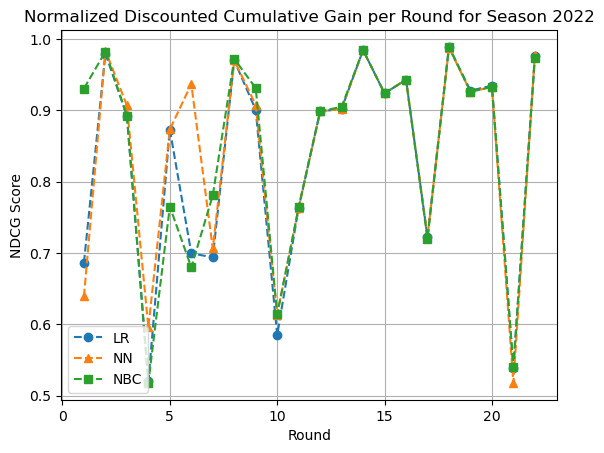

In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def calculate_dcg(relevances, p):
    dcg = 0
    for i in range(p):
        dcg += (2 ** relevances[i] - 1) / np.log2(i + 2)
    return dcg

def calculate_ndcg(relevances, p):
    dcg = calculate_dcg(relevances, p)
    idcg = calculate_dcg(sorted(relevances, reverse=True), p)
    return dcg / idcg if idcg != 0 else 0

def map_true_relevances_to_predicted_order(true_relevances, predicted_relevances):
    # print(f"true_relevances: {true_relevances}")
    # print(f"predicted_relevances: {predicted_relevances}")
    sorted_indices = np.argsort(predicted_relevances)[::-1]
    # print(f"sorted_indices: {sorted_indices}")
    mapped_true_relevances = np.array(true_relevances)[sorted_indices]
    # print(f"mapped_true_relevances: {mapped_true_relevances}")
    return mapped_true_relevances

#Finding season winners based on points
points_system = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}
# Function to assign points based on predicted position
def assign_points(df):
    df['predicted_points'] = df.groupby('round').cumcount() + 1
    df['predicted_points'] = df['predicted_points'].map(points_system).fillna(0)
    return df

def assign_relevance(values):
    # Sorting the list in ascending order
    sorted_values = sorted(values)
    # Assigning points: highest (10) to lowest (1)
    points = {value: 10 - i for i, value in enumerate(sorted_values)}
    rel = [points[val] for val in values]
    return rel

def lr(X_train, y_train, X_test, y_test, output=False):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    logreg = LogisticRegression(penalty='l1', solver='saga', C=10.0, max_iter=1500)
    logreg.fit(X_train_scaled, y_train)

    # probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]
    # data_2022['pred_probability'] = probabilities
    # driver_probabilities = data_2022.groupby('driver_name')['pred_probability'].mean().sort_values(ascending=False)
    # top_10_finishers = driver_probabilities.head(10)
    # y_pred = neuralnet.predict(X_test_scaled)
    
    data_2022 = data[data['season'] == 2022].copy()
    data_2022.loc[:, 'pred_probability'] = logreg.predict_proba(X_test_scaled)[:, 1]
    
    top_10_predictions = data_2022.groupby('round').apply(lambda x: x.nlargest(10, 'pred_probability')).reset_index(drop=True)

    unique_rounds = data_2022['round'].unique()

    mapped_revs = []
    ideal_revs = []

    for r in unique_rounds:
        round_predictions = top_10_predictions[top_10_predictions['round'] == r]
        round_predictions = round_predictions[['season', 'round', 'driver_name', 'pred_probability', 'podium']]
        round_predictions = round_predictions.reset_index(drop=True)
        round_predictions['pred_podium'] = round_predictions.index + 1
        
        # print(f"Round {r} predictions:")
        # display(round_predictions[['driver_name', 'podium', 'pred_podium']])
        
        podium_vals = round_predictions['podium'].tolist()
        podium_vals = [int(val) for val in podium_vals]
        true_relevances = assign_relevance(podium_vals)
        predicted_relevances = assign_relevance(round_predictions['pred_podium'].tolist())
        
        # Map true relevances to the order of predicted relevances
        mapped_true_relevances = map_true_relevances_to_predicted_order(true_relevances, predicted_relevances)
        # Calculate NDCG for the mapped true relevances
        ndcg_score_mapped = calculate_ndcg(mapped_true_relevances, len(mapped_true_relevances))
        # Calculate ideal NDCG for true relevances
        ideal_ndcg_score = calculate_ndcg(sorted(true_relevances, reverse=True), len(true_relevances))
        mapped_revs.append(ndcg_score_mapped)
        ideal_revs.append(ideal_ndcg_score)

    top_10_predictions = assign_points(top_10_predictions)
    # Summing up points for each driver
    season_points = top_10_predictions.groupby('driver_name')['predicted_points'].sum().reset_index()
    # Sorting drivers based on total points
    season_points = season_points.sort_values('predicted_points', ascending=False)

    y_test = y_test['driver_name'].tolist()
    y_pred = season_points['driver_name'].head(10).tolist()

    accuracy = accuracy_score(y_test, y_pred)
    comp_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    if output: print("Logistic Regression")
    if output: display(comp_df)

    pred_champ = season_points.iloc[0]['driver_name']
    pred_champ_points = season_points.iloc[0]['predicted_points']

    return (y_pred, accuracy, mapped_revs, ideal_revs, pred_champ, pred_champ_points)

def nn(X_train, y_train, X_test, y_test, output=False):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    neuralnet = MLPClassifier(hidden_layer_sizes=(80,20,40,5), activation='relu', solver='adam', alpha=1.2742749857031321, batch_size= 100, random_state=0, max_iter=2000)
    neuralnet.fit(X_train_scaled, y_train)

    # probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]
    # data_2022['pred_probability'] = probabilities
    # driver_probabilities = data_2022.groupby('driver_name')['pred_probability'].mean().sort_values(ascending=False)
    # top_10_finishers = driver_probabilities.head(10)
    # y_pred = neuralnet.predict(X_test_scaled)
    
    data_2022 = data[data['season'] == 2022].copy()
    data_2022.loc[:, 'pred_probability'] = neuralnet.predict_proba(X_test_scaled)[:, 1]
    
    top_10_predictions = data_2022.groupby('round').apply(lambda x: x.nlargest(10, 'pred_probability')).reset_index(drop=True)

    unique_rounds = data_2022['round'].unique()

    mapped_revs = []
    ideal_revs = []

    for r in unique_rounds:
        round_predictions = top_10_predictions[top_10_predictions['round'] == r]
        round_predictions = round_predictions[['season', 'round', 'driver_name', 'pred_probability', 'podium']]
        round_predictions = round_predictions.reset_index(drop=True)
        round_predictions['pred_podium'] = round_predictions.index + 1
        
        # print(f"Round {r} predictions:")
        # display(round_predictions[['driver_name', 'podium', 'pred_podium']])

        podium_vals = round_predictions['podium'].tolist()
        podium_vals = [int(val) for val in podium_vals]
        true_relevances = assign_relevance(podium_vals)
        predicted_relevances = assign_relevance(round_predictions['pred_podium'].tolist())

        # Map true relevances to the order of predicted relevances
        mapped_true_relevances = map_true_relevances_to_predicted_order(true_relevances, predicted_relevances)
        # Calculate NDCG for the mapped true relevances
        ndcg_score_mapped = calculate_ndcg(mapped_true_relevances, len(mapped_true_relevances))
        # Calculate ideal NDCG for true relevances
        ideal_ndcg_score = calculate_ndcg(sorted(true_relevances, reverse=True), len(true_relevances))
        mapped_revs.append(ndcg_score_mapped)
        ideal_revs.append(ideal_ndcg_score)

    top_10_predictions = assign_points(top_10_predictions)
    # Summing up points for each driver
    season_points = top_10_predictions.groupby('driver_name')['predicted_points'].sum().reset_index()
    # Sorting drivers based on total points
    season_points = season_points.sort_values('predicted_points', ascending=False)

    y_test = y_test['driver_name'].tolist()
    y_pred = season_points['driver_name'].head(10).tolist()

    accuracy = accuracy_score(y_test, y_pred)
    comp_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    if output: print("Neural Network")
    if output: display(comp_df)

    pred_champ = season_points.iloc[0]['driver_name']
    pred_champ_points = season_points.iloc[0]['predicted_points']

    return (y_pred, accuracy, mapped_revs, ideal_revs, pred_champ, pred_champ_points)

def nbc(X_train, y_train, X_test, y_test, output=False):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    nbc = GaussianNB(var_smoothing=2.848035868435799e-05)
    nbc.fit(X_train_scaled, y_train)

    # probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]
    # data_2022['pred_probability'] = probabilities
    # driver_probabilities = data_2022.groupby('driver_name')['pred_probability'].mean().sort_values(ascending=False)
    # top_10_finishers = driver_probabilities.head(10)
    # y_pred = neuralnet.predict(X_test_scaled)
    
    data_2022 = data[data['season'] == 2022].copy()
    data_2022.loc[:, 'pred_probability'] = nbc.predict_proba(X_test_scaled)[:, 1]
    
    top_10_predictions = data_2022.groupby('round').apply(lambda x: x.nlargest(10, 'pred_probability')).reset_index(drop=True)

    unique_rounds = data_2022['round'].unique()

    mapped_revs = []
    ideal_revs = []

    for r in unique_rounds:
        round_predictions = top_10_predictions[top_10_predictions['round'] == r]
        round_predictions = round_predictions[['season', 'round', 'driver_name', 'pred_probability', 'podium']]
        round_predictions = round_predictions.reset_index(drop=True)
        round_predictions['pred_podium'] = round_predictions.index + 1
        
        # print(f"Round {r} predictions:")
        # display(round_predictions[['driver_name', 'podium', 'pred_podium']])

        podium_vals = round_predictions['podium'].tolist()
        podium_vals = [int(val) for val in podium_vals]
        true_relevances = assign_relevance(podium_vals)
        predicted_relevances = assign_relevance(round_predictions['pred_podium'].tolist())

        # Map true relevances to the order of predicted relevances
        mapped_true_relevances = map_true_relevances_to_predicted_order(true_relevances, predicted_relevances)
        # Calculate NDCG for the mapped true relevances
        ndcg_score_mapped = calculate_ndcg(mapped_true_relevances, len(mapped_true_relevances))
        # Calculate ideal NDCG for true relevances
        ideal_ndcg_score = calculate_ndcg(sorted(true_relevances, reverse=True), len(true_relevances))
        mapped_revs.append(ndcg_score_mapped)
        ideal_revs.append(ideal_ndcg_score)

    top_10_predictions = assign_points(top_10_predictions)
    # Summing up points for each driver
    season_points = top_10_predictions.groupby('driver_name')['predicted_points'].sum().reset_index()
    # Sorting drivers based on total points
    season_points = season_points.sort_values('predicted_points', ascending=False)

    y_test = y_test['driver_name'].tolist()
    y_pred = season_points['driver_name'].head(10).tolist()

    accuracy = accuracy_score(y_test, y_pred)
    comp_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    if output: print("Naive Bayes Classifier")
    if output: display(comp_df)

    pred_champ = season_points.iloc[0]['driver_name']
    pred_champ_points = season_points.iloc[0]['predicted_points']

    return (y_pred, accuracy, mapped_revs, ideal_revs, pred_champ, pred_champ_points)

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]
features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data = pd.read_csv('./data/preprocessed_df.csv')
# data['top_10_finish'] = np.where(data['podium'] <= 10, 1, 0)
data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
# y = data['podium']
# y = data['top_10_finish']
y = data['season_end_top_10']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]

data_w_points = pd.read_csv('./data/final_df.csv')
y_test = data_w_points[data_w_points['season'] == 2022]
y_test = y_test.groupby('driver_name')['points'].sum().reset_index()
y_test = y_test.sort_values('points', ascending=False)
y_test = y_test.iloc[0:10].reset_index(drop=True)

(lr_pred, lr_acc, lr_mapped_revs, lr_ideal_revs, lr_champ, lr_champ_pts) = lr(X_train, y_train, X_test, y_test, output=True)
(nn_pred, nn_acc, nn_mapped_revs, nn_ideal_revs, nn_champ, nn_champ_pts) = nn(X_train, y_train, X_test, y_test, output=True)
(nbc_pred, nbc_acc, nbc_mapped_revs, nbc_ideal_revs, nbc_champ, nbc_champ_pts) = nbc(X_train, y_train, X_test, y_test, output=True)

# print("Accuracy for 2022 season:", nn_acc)
# print(nn_pred)
# print(f"Champion of 2022 season: {champ} with {champ_pts} points")
lr_mean_mapped_revs = np.mean(lr_mapped_revs)
nn_mean_mapped_revs = np.mean(nn_mapped_revs)
nbc_mean_mapped_revs = np.mean(nbc_mapped_revs)

results = {"model": ["LR", "NN", "NBC"], "accuracy": [lr_acc, nn_acc, nbc_acc], "pred_champion": [lr_champ, nn_champ, nbc_champ], "pred_champion_points": [lr_champ_pts, nn_champ_pts, nbc_champ_pts], "mean_ndcg": [lr_mean_mapped_revs, nn_mean_mapped_revs, nbc_mean_mapped_revs]}
results_df = pd.DataFrame(results)
display(results_df)
display(results_df[['model', 'mean_ndcg']])
# display(y_test)

plt.figure()
plt.plot(range(1, len(lr_mapped_revs)+1), lr_mapped_revs, linestyle='--', marker='o', label='LR')
plt.plot(range(1, len(nn_mapped_revs)+1), nn_mapped_revs, linestyle='--',marker='^', label='NN')
plt.plot(range(1, len(nbc_mapped_revs)+1), nbc_mapped_revs, linestyle='--',marker='s', label='NBC')
plt.xlabel('Round')
plt.ylabel('NDCG Score')
plt.legend()
plt.title('Normalized Discounted Cumulative Gain per Round for Season 2022')
plt.grid(True)
plt.show()

# Learning Curves with Chosen Features

/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


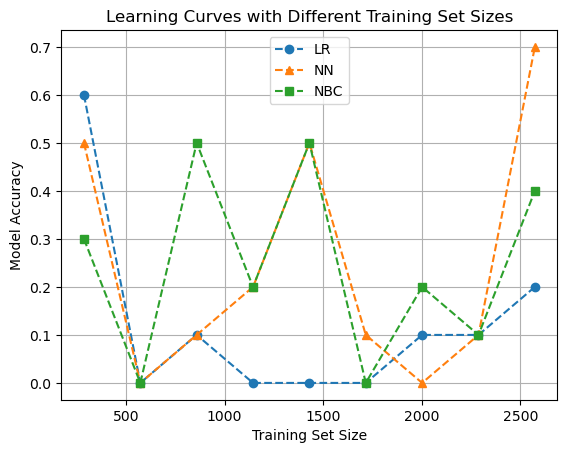

In [120]:
# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]

features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data = pd.read_csv('./data/preprocessed_df.csv')
# data['top_10_finish'] = np.where(data['podium'] <= 10, 1, 0)
data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
# y = data['podium']
# y = data['top_10_finish']
y = data['season_end_top_10']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]

data_w_points = pd.read_csv('./data/final_df.csv')
y_test = data_w_points[data_w_points['season'] == 2022]
y_test = y_test.groupby('driver_name')['points'].sum().reset_index()
y_test = y_test.sort_values('points', ascending=False)
y_test = y_test.iloc[0:10].reset_index(drop=True)
# y_test computes the actual final standing for each driver at the end of the season


#  ===

X_train_partitions = np.array_split(X_train, 10) # for different train sizes
y_train_partitions = np.array_split(y_train, 10) # for different train sizes

lr_accs = []
nn_accs = []
nbc_accs = []
train_size = []
X_train_var = pd.DataFrame()
y_train_var = pd.DataFrame()
for i in range(len(X_train_partitions)-1, 0, -1):
    X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
    y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
    X_train_var = X_train_var.sort_index()
    # print(X_train_var.shape)
    # display(X_train_var)

    (lr_pred, lr_acc, lr_mapped_revs, lr_ideal_revs, lr_champ, lr_champ_pts) = lr(X_train_var, y_train_var, X_test, y_test)
    (nn_pred, nn_acc, nn_mapped_revs, nn_ideal_revs, nn_champ, nn_champ_pts) = nn(X_train_var, y_train_var, X_test, y_test)
    (nbc_pred, nbc_acc, nbc_mapped_revs, nbc_ideal_revs, nbc_champ, nbc_champ_pts) = nbc(X_train_var, y_train_var, X_test, y_test)
    train_size.append(X_train_var.shape[0])
    lr_accs.append(lr_acc)
    nn_accs.append(nn_acc)
    nbc_accs.append(nbc_acc)

plt.figure()
plt.plot(train_size, lr_accs, linestyle='--', marker='o', label='LR')
plt.plot(train_size, nn_accs, linestyle='--', marker='^', label='NN')
plt.plot(train_size, nbc_accs, linestyle='--', marker='s', label='NBC')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy')
plt.legend()
plt.title('Learning Curves with Different Training Set Sizes')
plt.grid(True)
plt.show()


	y_test	        y_pred
1	max verstappen	max verstappen  1
2	charles leclerc	charles leclerc 1
3	sergio perez	sergio perez    1
4	george russell	carlos sainz    0
5	lewis hamilton	george russell  0
6	carlos sainz	lewis hamilton  0
7	lando norris	lando norris    1
8	esteban ocon	esteban ocon    1
9	fernando alonso	fernando alonso 1
10	valtteri bottas	valtteri bottas 1

acc = 7/10

# Original LR Untouched

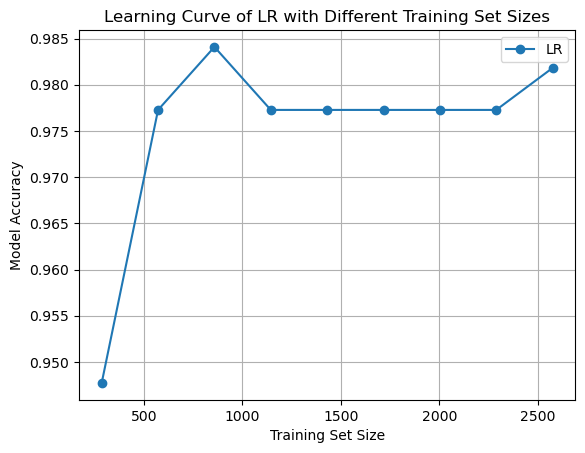

In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

data = pd.read_csv('./data/preprocessed_df.csv')
data_w_points = pd.read_csv('./data/final_df.csv')

def lr(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_train)

    probabilities = logreg.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == 2022].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = logreg.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]
features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
y = data['season_end_top_10']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]
y_test = y[data['season'] == 2022]

X_train_partitions = np.array_split(X_train, 10) # for different train sizes
y_train_partitions = np.array_split(y_train, 10) # for different train sizes

lr_accs = []
train_size = []
X_train_var = pd.DataFrame()
y_train_var = pd.DataFrame()
for i in range(len(X_train_partitions)-1, 0, -1):
    X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
    y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
    X_train_var = X_train_var.sort_index()
    # print(X_train_var.shape)
    # display(X_train_var)

    (lr_pred, lr_acc, lr_top10) = lr(X_train_var, y_train_var, X_test, y_test)
    train_size.append(X_train_var.shape[0])
    lr_accs.append(lr_acc)

plt.figure()
plt.plot(train_size, lr_accs, marker='o', label='LR')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy')
plt.legend()
plt.title('Learning Curve of LR with Different Training Set Sizes')
plt.grid(True)
plt.show()

driver     y_test  y_pred
driver1,   true,   true    1
driver2,   false,  true    0
driver3,   true,   false   0
driver4,   false,  false   1
driver5,   true,   false   0
driver6,   false,  fasle   1
driver7,   false,  fasle   1
driver8,   false,  fasle   1
driver9,   true,   true    1
driver10,  true,   false   0

acc = 6/10

For every driver, is it in the top 10 (true or false)

For all rounds in season 2022, each driver has either true or false

# Original NN Untouched
**Notice that this implementation uses the second method!**
```
data['top_10_finish'] = np.where(data['podium'] <= 10, 1, 0)
X = data[all_features]
y = data['top_10_finish']
```

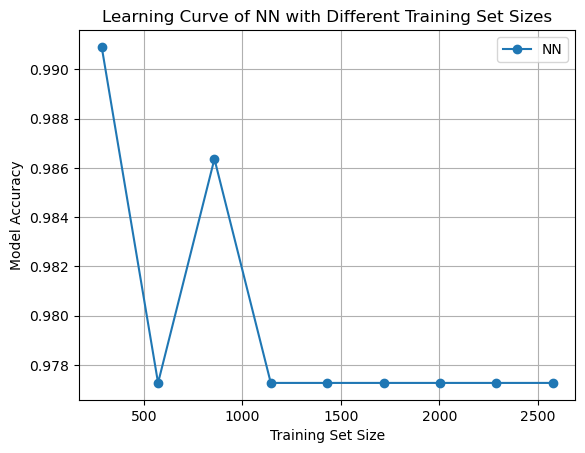

In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

data = pd.read_csv('./data/preprocessed_df.csv')

def nn(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    neuralnet = MLPClassifier(solver='sgd', batch_size= 100, random_state=0, max_iter=1000)
    neuralnet.fit(X_train_scaled, y_train)

    probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == 2022].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = neuralnet.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]
features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
y = data['season_end_top_10']

# X = data[all_features]
# y = data['top_10_finish']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]
y_test = y[data['season'] == 2022]

X_train_partitions = np.array_split(X_train, 10) # for different train sizes
y_train_partitions = np.array_split(y_train, 10) # for different train sizes

nn_accs = []
train_size = []
X_train_var = pd.DataFrame()
y_train_var = pd.DataFrame()
for i in range(len(X_train_partitions)-1, 0, -1):
    X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
    y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
    X_train_var = X_train_var.sort_index()
    # print(X_train_var.shape)
    # display(X_train_var)

    (nn_pred, nn_acc, nn_top10) = nn(X_train_var, y_train_var, X_test, y_test)
    train_size.append(X_train_var.shape[0])
    nn_accs.append(nn_acc)

plt.figure()
plt.plot(train_size, nn_accs, marker='o', label='NN')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy')
plt.legend()
plt.title('Learning Curve of NN with Different Training Set Sizes')
plt.grid(True)
plt.show()


# Original NBC Untouched

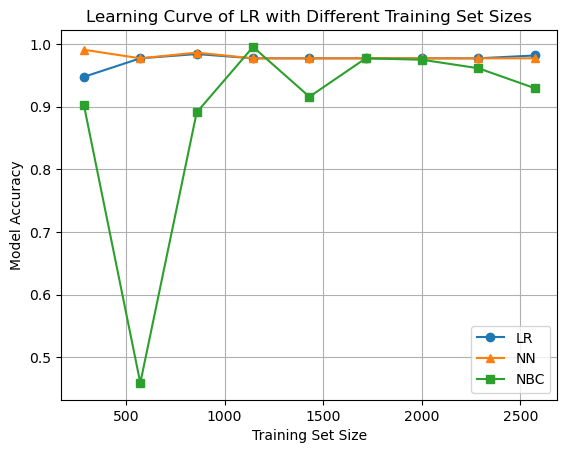

In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

data = pd.read_csv('./data/preprocessed_df.csv')
data_w_points = pd.read_csv('./data/final_df.csv')

def nbc(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    nbc = GaussianNB()
    nbc.fit(X_train_scaled, y_train)

    probabilities = nbc.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == 2022].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = nbc.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]

features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
y = data['season_end_top_10']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]
y_test = y[data['season'] == 2022]

X_train_partitions = np.array_split(X_train, 10) # for different train sizes
y_train_partitions = np.array_split(y_train, 10) # for different train sizes

nbc_accs = []
train_size = []
X_train_var = pd.DataFrame()
y_train_var = pd.DataFrame()
for i in range(len(X_train_partitions)-1, 0, -1):
    X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
    y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
    X_train_var = X_train_var.sort_index()
    # print(X_train_var.shape)
    # display(X_train_var)

    (nbc_pred, nbc_acc, nbc_top10) = nbc(X_train_var, y_train_var, X_test, y_test)
    train_size.append(X_train_var.shape[0])
    nbc_accs.append(nbc_acc)

plt.figure()
plt.plot(train_size, lr_accs, marker='o', label='LR')
plt.plot(train_size, nn_accs, marker='^', label='NN')
plt.plot(train_size, nbc_accs, marker='s', label='NBC')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy')
plt.legend()
plt.title('Learning Curve of LR with Different Training Set Sizes')
plt.grid(True)
plt.show()

Merging the "Originals"